We will use a virtual environment for this task, names simply '.venv'. 
This environment is not stored on GitHub due to the size of python libraries. To recreate the environment, please run :
    pip install -r requirments.txt

In [1]:
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import collections

In [2]:
# Upload data
data = pd.read_csv('task_data_churned.csv')

In [3]:
# Show first few rows of data
print(f'Sample of data :\n')
print(data.head())

Sample of data :

   ws_users_activated  ws_users_deactivated  ws_users_invited  \
0                   3                     2                 0   
1                   6                     1                 0   
2                   2                     0                 0   
3                   1                     0                 0   
4                   1                     0                 0   

   action_create_project  action_export_report  action_api_and_webhooks  \
0                      5                     8                        0   
1                     35                   106                        0   
2                      3                     3                        0   
3                      0                     0                        0   
4                      0                     0                        1   

   action_time_entries_via_tracker  action_start_trial  action_import_csv  \
0                                0                   0         

In [4]:
# INFO
print(f'Basic information :\n')
print(data.info())

Basic information :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ws_users_activated               2502 non-null   int64  
 1   ws_users_deactivated             2502 non-null   int64  
 2   ws_users_invited                 2502 non-null   int64  
 3   action_create_project            2502 non-null   int64  
 4   action_export_report             2502 non-null   int64  
 5   action_api_and_webhooks          2502 non-null   int64  
 6   action_time_entries_via_tracker  2502 non-null   int64  
 7   action_start_trial               2502 non-null   int64  
 8   action_import_csv                2502 non-null   int64  
 9   action_create_invoice            2502 non-null   int64  
 10  action_lock_entries              2502 non-null   int64  
 11  action_add_targets               2502 non-null   int64  
 12 

From information printed above, we see that we have NaN values in following  columns : action_gps_tracking, action_screenshots, action_create_custom_field and country. Our first task is to examine this data and see if we can fill in the missing data. We will start with columns 'action' with the assumption these columns refer to actions that had or had not taken place and believing that a NaN value, aka missing value, comes from non-existing data in the database and can be replaced with an integer of 0. 

To test that theory we will print all unique values from each 'action' column.

In [5]:
# Dealing with NaN values in action columns
columns_to_test = ['action_gps_tracking', 'action_screenshots', 'action_create_custom_field']

for col in columns_to_test:
    print(col + ':')
    temp = data[col].unique()
    temp.sort()
    print(str(temp) + '\n')

action_gps_tracking:
[ 1.  2.  3.  4.  5.  6.  8. nan]

action_screenshots:
[ 1.  2.  3.  4.  5.  6.  8. 11. nan]

action_create_custom_field:
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  16.  17.  18.  19.  20.  21.  24.  25.  26.  28.  30.  32.  35.  42.
  46.  52.  53.  54.  56.  57.  61.  65.  66.  81. 106.  nan]



As we see that our initial assumption was correct since no columns have 0 values in any of the rows, we continue to replace NaN values with 0.

In [6]:
for col in columns_to_test:
    data[col] = data[col].apply(lambda x: 0 if np.isnan(x) else int(x))

As for the missing values in the country column, since it makes up for less than 5% of the data, we will simply exclude the rows with missing values. We could also replace it with the most frequent value from the country column, but we chose the exclusion of the missing data due to a low percentage.

In [7]:
data.dropna(subset='country',inplace=True) 
data.reset_index(inplace=True)

Describe function will show mean values, standard deviations, minimum and maximum values and similar statistical metrics that should help with better understanding the data. This will also provide us with initial knowledge about range of features. It is important in tasks like this to take range into consideration, so that one feature does not take dominant role in classification.

In [8]:
def visualise(col:pd.Series,pie=False) :
    if col.dtypes!='float64' :
        plt.figure()
        x = collections.Counter(col);
        l = range(len(x.keys()));
        
        x = dict(sorted(x.items()))
        
        bar = plt.barh(l, x.values(), align='center',height=0.5);
        
        plt.bar_label(bar,rotation=0)
        plt.yticks(l, x.keys());

        plt.ylabel('values')
        plt.xlabel('number of samples')
        plt.title(col.name)
        
        if pie :
            plt.figure()
            percentage =  [format(val/sum(list(x.values()))*100,'.2f')+'%' for val in list(x.values())]
            plt.pie(x.values(), labels=percentage, shadow = True)
            plt.legend(labels=x.keys())
            plt.title(col.name)

    else :
        plt.plot(col)
        plt.ylabel('values')
        plt.xlabel('sample')
        plt.title(col.name)
    

Now that we have a set of non-null features values that are either integer, string (country) or float(revenue), we can continue with the exploration and analysis of the data. 
The first order of business is dataset imbalance.

['No' 'Yes']


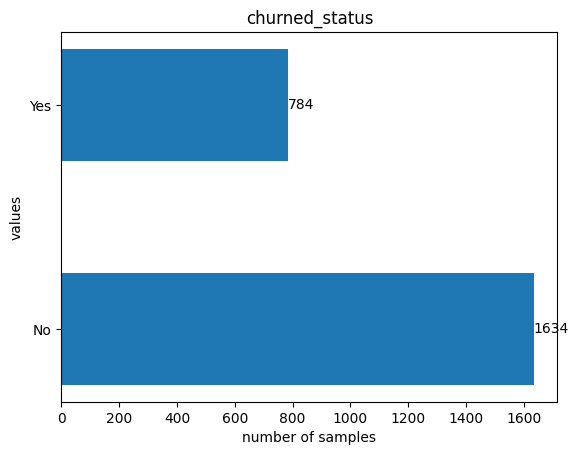

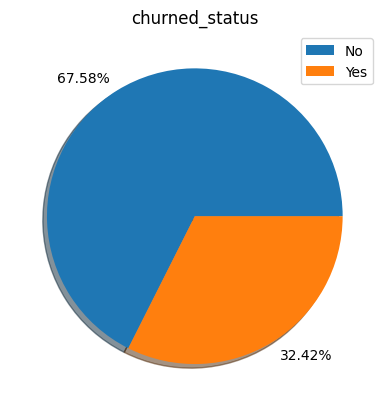

In [9]:
col = 'churned_status'
visualise(data[col],pie=True)
temp = data[col].unique()
temp.sort()
print(temp)

The dataset shows a level of imbalance close to 2:1 proportion, which will affect our classfication strategy. Had the imbalance been greater, we would have to use one or more of the many ways of balancing it out, such as undersampling, oversampling, SMOTE-ing, sinthetically creating more articles etc. However, the imbalance level is low enough to add stratified sampling (already default in train_test_split) and class weights and use one of the metrics suitable for imbalanced datasets, such as f1score or roc_auc. As for the class weights, they are calculated inside the Classifiers as n_samples / (n_classes * np.bincount(y)).

We will visualise the distribution of feature values and relationship between outputs and features to have a better idea of what the features represent,if there are any outliers, how relevant the features are to the outcome, etc. Then, we will implement a normalization/standardization strategy to make features equally important in the classification proccess.

The relationship between features and output will be calculated with a cohort function. Each feature will be binned into N bins. For each bin, we will calculate a mean value of output (after transforming each sample's output into 0 or 1). If we notice that the output value shows similar values over all bins, we decide that the feature is irrelevant. We also declare the feature irrelevant in case that the number of unique values is low and most samples have same or similar values. 

In [10]:
data['churned_status'] = data['churned_status'].apply(lambda x : 1 if x=='Yes' else 0)

/var/folders/y5/75pd3v1141z97gwsh6v5cytc0000gn/T/ipykernel_16405/1683670757.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = data.groupby(groups)[col].mean()
/var/folders/y5/75pd3v1141z97gwsh6v5cytc0000gn/T/ipykernel_16405/1683670757.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  height = [len(val) for val in data.groupby(groups).groups.values()]
/var/folders/y5/75pd3v1141z97gwsh6v5cytc0000gn/T/ipykernel_16405/1683670757.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior

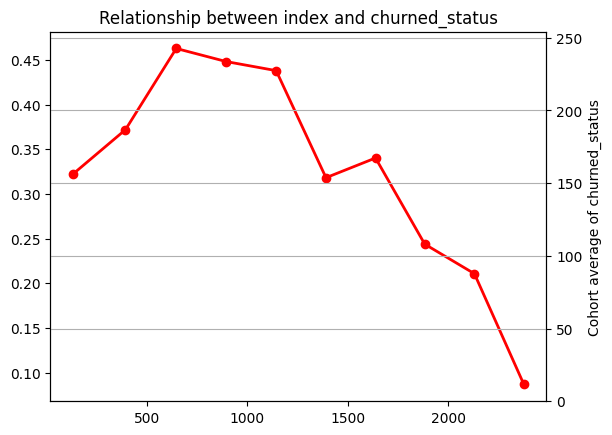

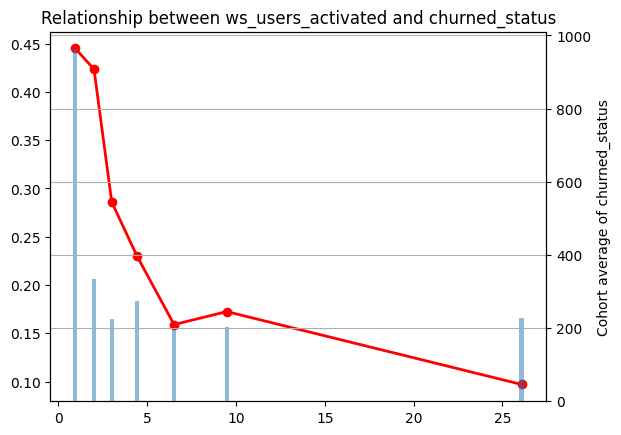

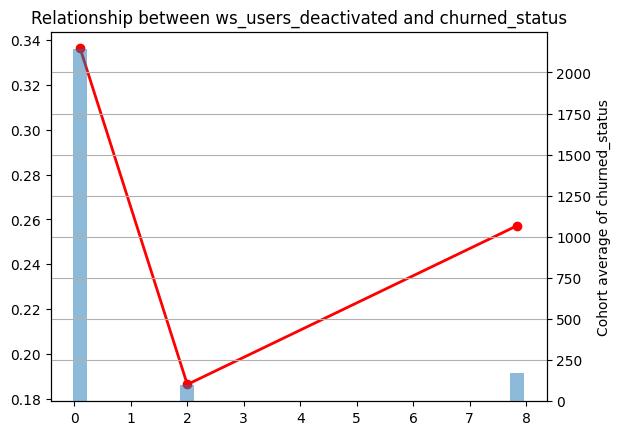

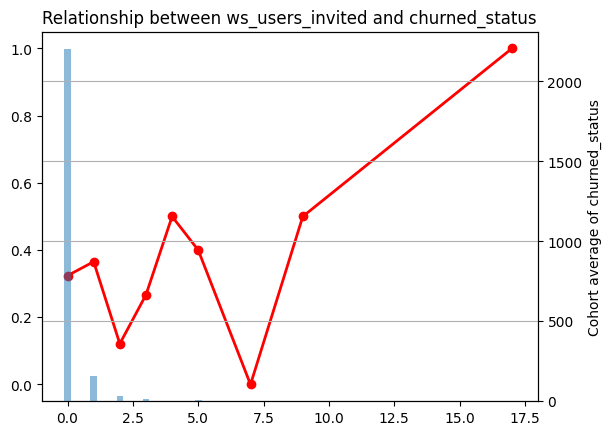

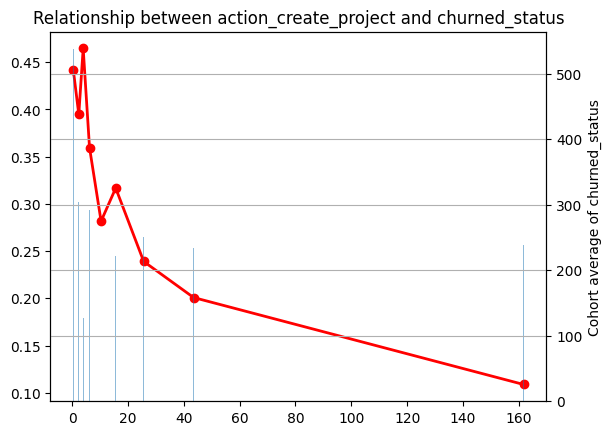

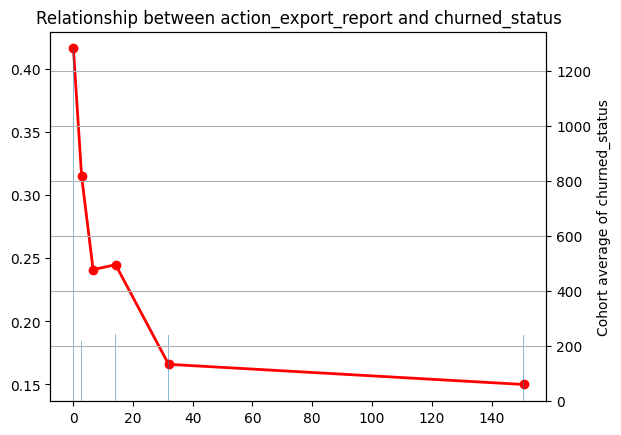

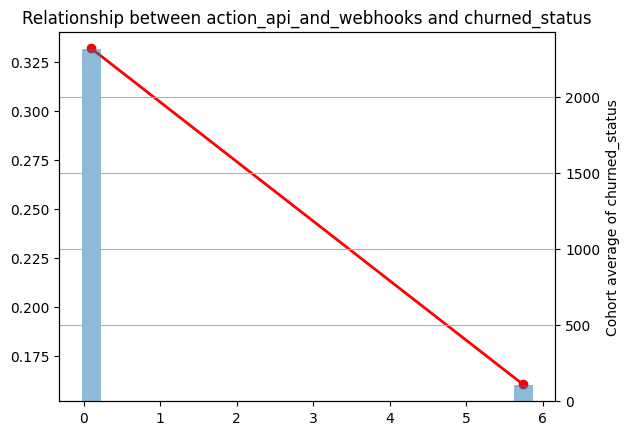

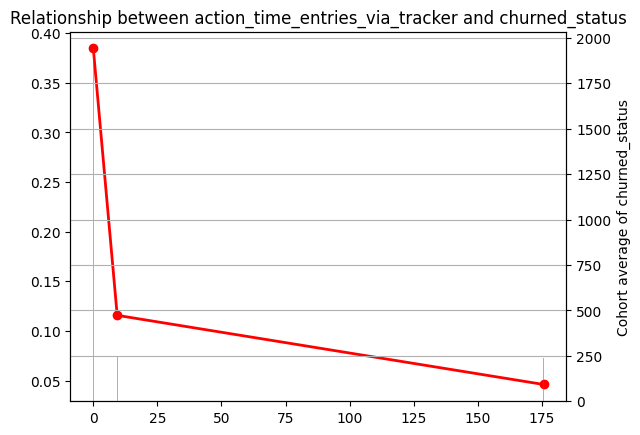

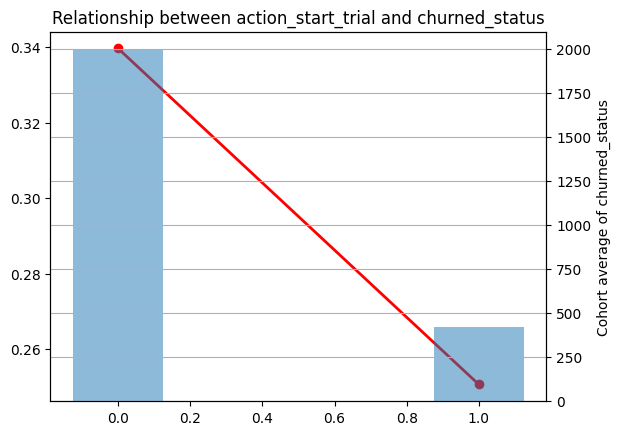

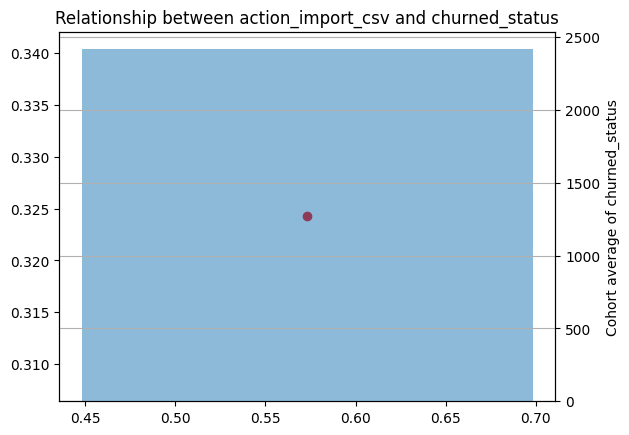

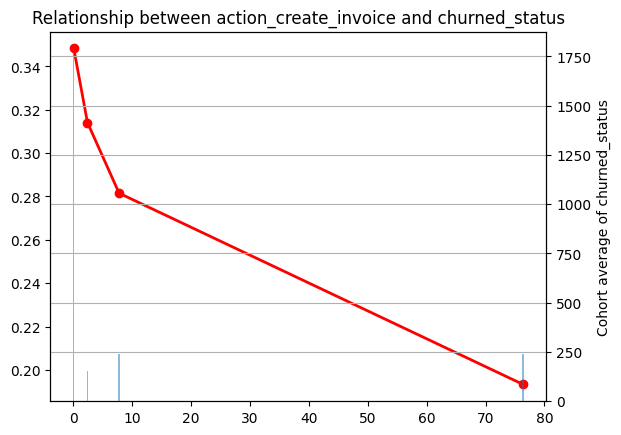

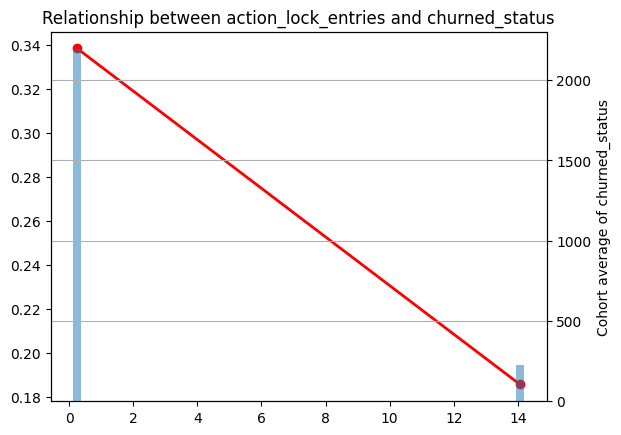

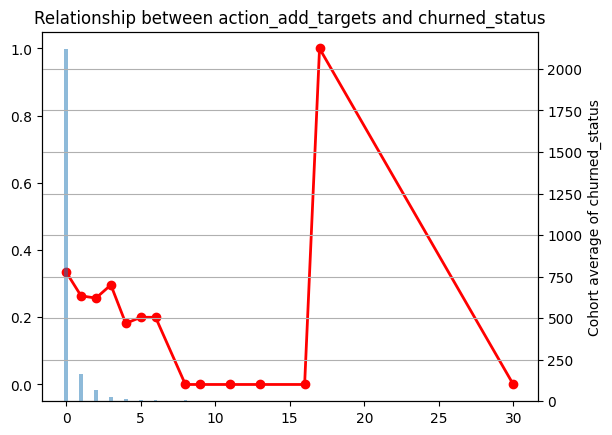

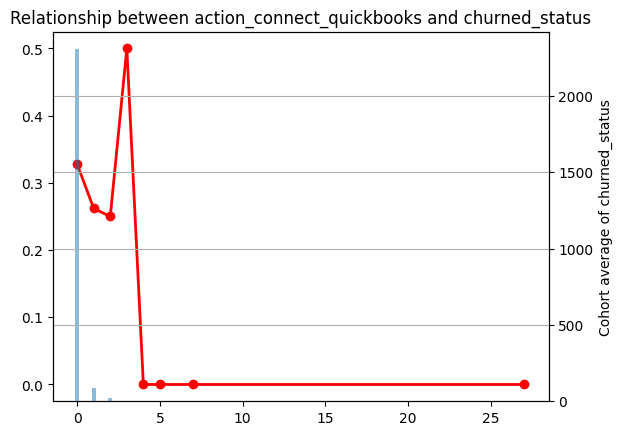

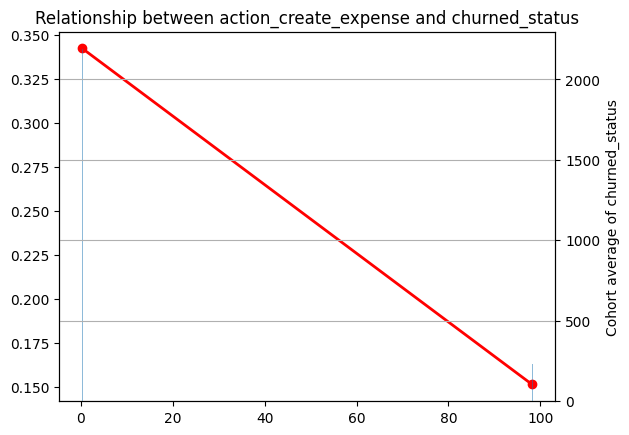

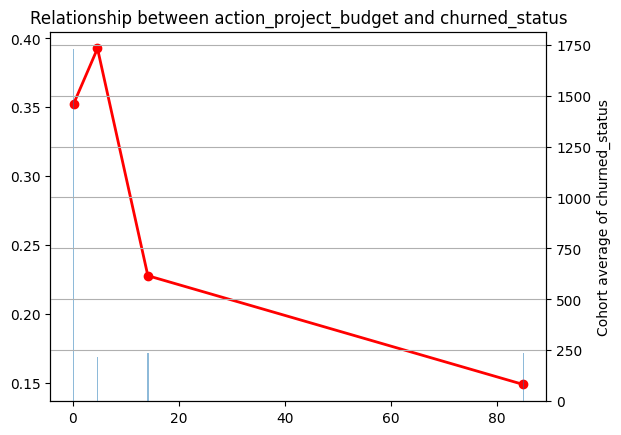

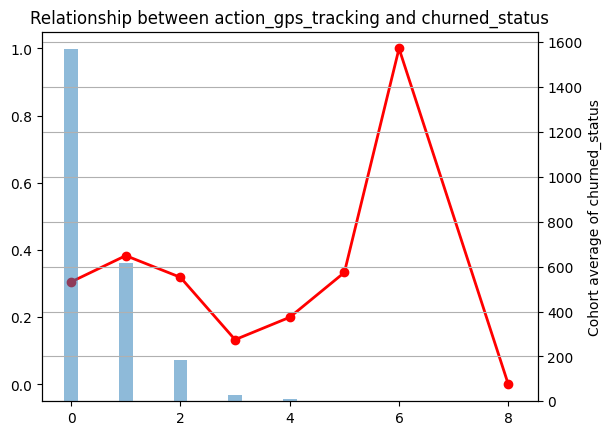

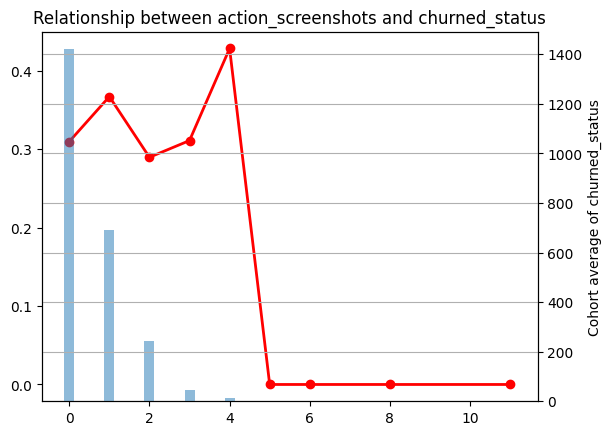

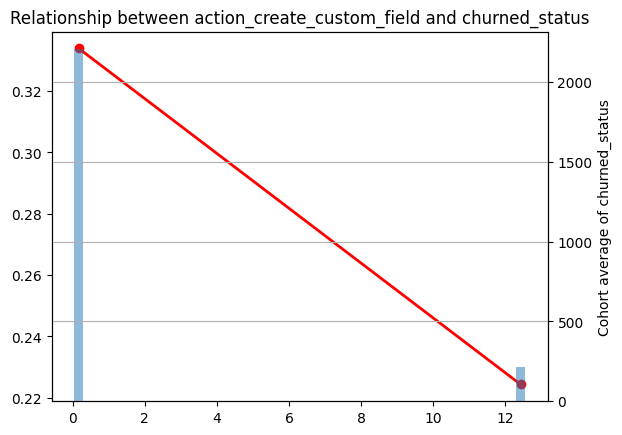

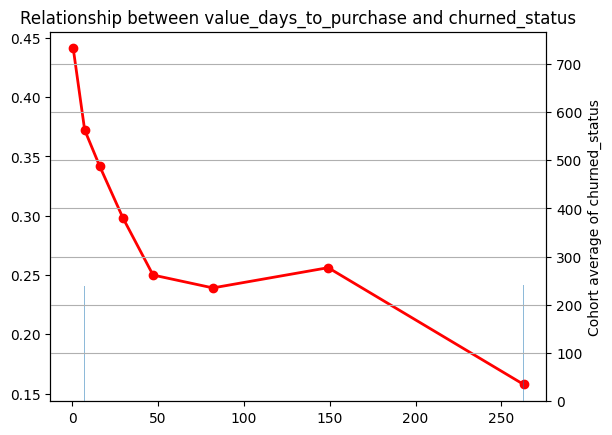

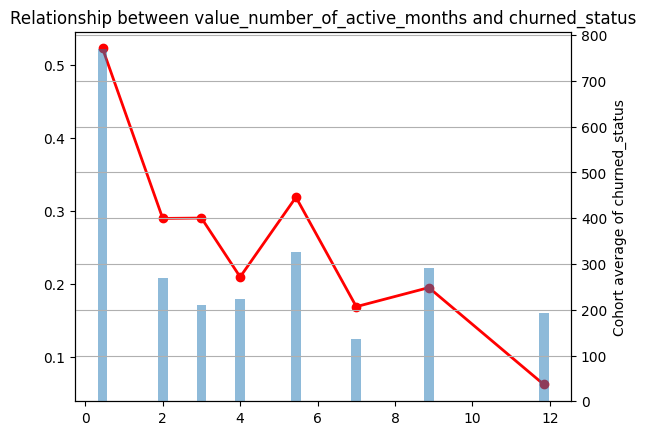

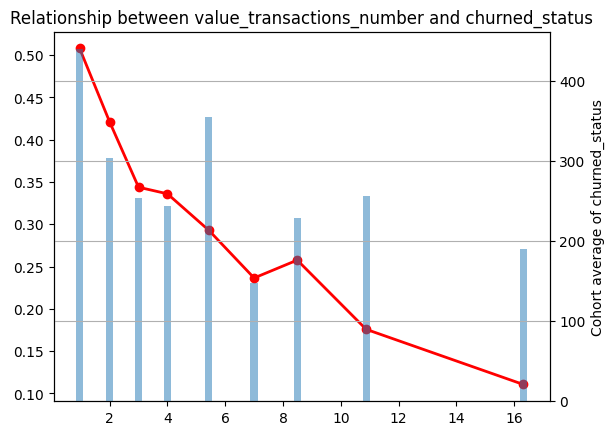

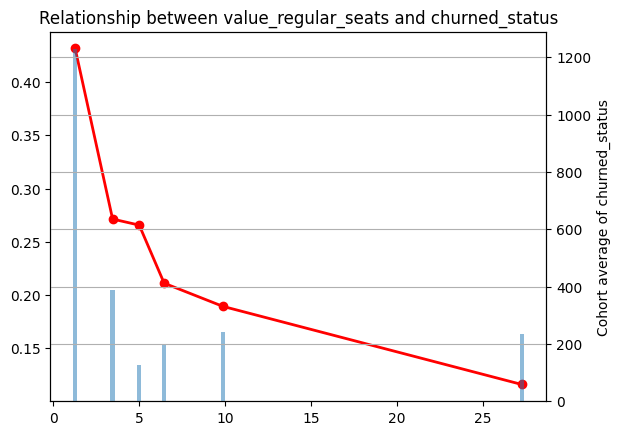

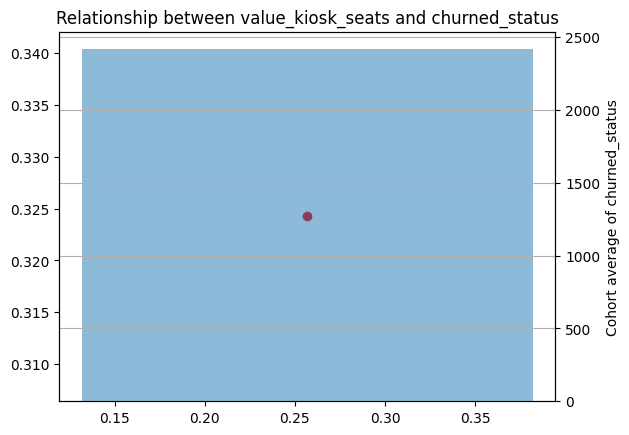

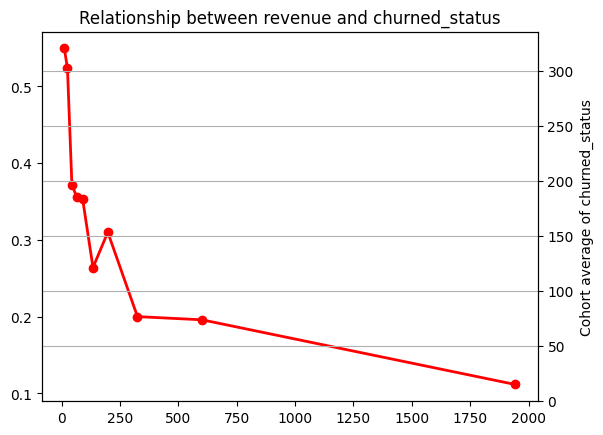

In [11]:
def cohort(data : pd.DataFrame, col : str, target_val : str, ncohort : int = 10, thresh = 15, categorical : bool = False):
    if categorical or (len(data[col].unique()) < thresh):
        # centers are actual values
        centers = list(data[col].unique())
        centers.sort()
        height = [len(val) for val in data.groupby(col).groups.values()]
        # we compare against the mean value over the bin
        y_mean = data.groupby(col)[target_val].mean()
        df_to_plot = pd.DataFrame({col: centers, target_val: y_mean.values})
    else:
        groups = pd.qcut(data[col], q=ncohort, duplicates = 'drop')
        # centers are mean values
        centers = data.groupby(groups)[col].mean()
        height = [len(val) for val in data.groupby(groups).groups.values()]
        # we compare against the mean value over the bin
        y_mean = data.groupby(groups)[target_val].mean()
        df_to_plot = pd.DataFrame({col: centers.values, target_val: y_mean.values})
    
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(col, target_val, data = df_to_plot, marker = 'o', linewidth = 2,color= 'red')
    ax2.bar(centers,height,align='center',width=0.25,alpha=0.5)
    #plt.yticks(l, x.keys());
    plt.xlabel('Cohort average of '+col)
    plt.ylabel('Cohort average of '+target_val)
    plt.grid(visible=True)
    plt.title("Relationship between "+col+" and "+target_val)
    plt.show()
    return df_to_plot


#df = cohort(data,'action_import_csv','churned_status')

for column in data.columns: 
    if column not in ['churned_status', 'country']  :
        cohort(data,column,'churned_status')
        

Graphs above show which columns should be excluded. They are listed in the exclude variable.

In [12]:
col_list = list(data.columns)
exclude = ['churned_status','value_kiosk_seats','action_create_custom_field','action_create_expense',\
                 'action_screenshots','action_start_trial','action_gps_tracking','action_project_budget',\
                 'action_add_targets','action_api_and_webhooks','action_import_csv','action_connect_quickbooks']
col_list = [x for x in col_list if x not in exclude]

col_categorical = ['country']
col_list.remove('country')

In [13]:
# DESCRIBE
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,2418.0,1263.052109,717.409139,0.0,647.250,1268.500,1882.750,2501.000
ws_users_activated,2418.0,5.198925,9.555736,0.0,1.000,2.000,6.000,158.000
ws_users_deactivated,2418.0,0.742763,3.275768,0.0,0.000,0.000,0.000,73.000
ws_users_invited,2418.0,0.144748,0.662657,0.0,0.000,0.000,0.000,17.000
action_create_project,2418.0,26.585194,73.927866,0.0,2.000,8.000,25.000,1923.000
action_export_report,2418.0,20.436725,68.397778,0.0,0.000,1.000,14.000,1431.000
action_api_and_webhooks,2418.0,0.345740,2.898572,0.0,0.000,0.000,0.000,127.000
action_time_entries_via_tracker,2418.0,18.315964,112.463586,0.0,0.000,0.000,0.000,3382.000
action_start_trial,2418.0,0.173284,0.378571,0.0,0.000,0.000,0.000,1.000
action_import_csv,2418.0,0.573201,4.336085,0.0,0.000,0.000,0.000,120.000


We have to map the categorical country variable from its string representation to integer values. Then, since it is a categorical variable, we use one hot encoding for its representation.
Other columns could not be classified as categorical, so for them we go with the normalization procedure. Standardization procedure takes into acount standard deviation and is better for problems where outliers are more common.

In [14]:

bin_enc = OneHotEncoder(min_frequency=3,sparse=False) 
normed = bin_enc.fit_transform(data['country'].values.reshape(-1, 1))
column_names = ['country'+str(x) for x in range(0,normed.shape[1])]
normed = pd.DataFrame(normed,columns=column_names)

'''
lab_enc = LabelEncoder() 
normed =  pd.DataFrame(lab_enc.fit_transform(data['country']),columns=['country'])
data['country'] = normed
col_list = col_list + ['country']
'''
scaler = MinMaxScaler(feature_range = (0,1))
scaled = pd.DataFrame(scaler.fit_transform(data[col_list]),columns=col_list)

X = scaled.join(normed)
#X = scaled
X.drop(columns='index',inplace=True)
y = data.loc[:,'churned_status']

/Users/isidoraalimpic/Desktop/smth/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


We now create a train and test set and start training the classifiers.

Four classifiers were chosen, all four are representativies of the traditional classification strategies. Neural networks or more complex classifiers would also work for such a classification problem, but the four chosen classifiers have an important advantage when it comes to the speed of execution. Since we have well balanced dataset, not too many features, we safely choose the four underneath. 

As for the hyperparameters, we again go with a traditional approach, meaning a GridSearch. We also use a crossvalidation with 10 k-folds. And for the performance metric, we go with the f1 score.F1_score and roc_auc are most often used metrics when imbalanced datasets are in question. However, f1_score puts a greater accent on the positive class.

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42) #random_state set for reproducible results

In [16]:
# Logistic Regression
base_model = LogisticRegression(solver = 'liblinear',class_weight='balanced')
test_par = {'C': [.005, .01, .04, .08, .16, .32, .64, .75, .95],
            'penalty' : ['l1','l2']          
           }
LR_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = ['roc_auc','f1'], refit='f1', cv = 10, verbose = 4, n_jobs = -1)
LR_gsearch.fit(X_train,y_train)
LR_result_df = pd.DataFrame(LR_gsearch.cv_results_)

print(LR_gsearch.best_score_)
print(LR_gsearch.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[CV 4/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 7/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 2/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 1/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 5/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 8/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 3/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 9/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 6/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 10/10] END C=0.005, penalty=l1; f1: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV 1/10] END C=0.005, penalty=l2; f1: (test=0.522) roc_auc: (test=0.

In [17]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 2/10] END max_depth=2, max_features=sqrt, n_estimators=10; f1: (test=0.537) roc_auc: (test=0.736) total time=   0.1s
[CV 6/10] END max_depth=2, max_features=sqrt, n_estimators=10; f1: (test=0.647) roc_auc: (test=0.789) total time=   0.1s
[CV 1/10] END max_depth=2, max_features=sqrt, n_estimators=10; f1: (test=0.500) roc_auc: (test=0.759) total time=   0.1s
[CV 5/10] END max_depth=2, max_features=sqrt, n_estimators=10; f1: (test=0.561) roc_auc: (test=0.702) total time=   0.1s
[CV 3/10] END max_depth=2, max_features=sqrt, n_estimators=10; f1: (test=0.525) roc_auc: (test=0.762) total time=   0.1s
[CV 8/10] END max_depth=2, max_features=sqrt, n_estimators=10; f1: (test=0.553) roc_auc: (test=0.749) total time=   0.1s
[CV 7/10] END max_depth=2, max_features=sqrt, n_estimators=10; f1: (test=0.584) roc_auc: (test=0.693) total time=   0.1s
[CV 4/10] END max_depth=2, max_features=sqrt, n_estimators=10; f1: (test=0.570) roc_auc: (

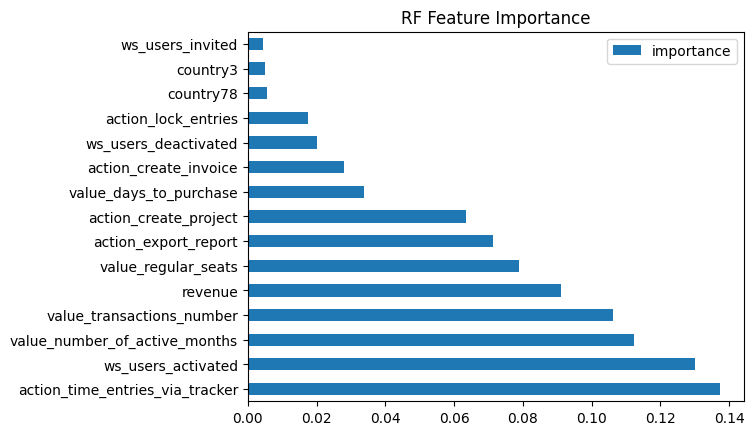

In [18]:
base_model = RandomForestClassifier(n_jobs = -1,class_weight='balanced')
test_par = {'max_depth' : [2,5,10],
            'max_features': ['sqrt', 'log2'],
            'n_estimators': [10,100,500,1000]}
RF_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = ['roc_auc','f1'], refit='f1', cv=10, verbose=4, n_jobs=-1)
RF_gsearch.fit(X,y)
RF_result_df = pd.DataFrame(RF_gsearch.cv_results_)

print(RF_gsearch.best_score_)
print(RF_gsearch.best_params_)

# Check feature importance
X_feature = X.columns.values
RF_feat = pd.DataFrame(data = RF_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance',ascending=False)[0:15].plot(kind='barh', title = 'RF Feature Importance')
plt.show() 

In [19]:
sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)
def get_weights(cls):
    class_weights_dict = {
        0: class_weights[0],
        1: class_weights[1],
    }

    return [class_weights_dict[cl] for cl in cls]

Fitting 10 folds for each of 384 candidates, totalling 3840 fits
[CV 1/10] END learning_rate=0.01, max_depth=5, min_child_weight=0.05, n_estimators=10; f1: (test=0.500) roc_auc: (test=0.792) total time=   0.0s
[CV 5/10] END learning_rate=0.01, max_depth=5, min_child_weight=0.05, n_estimators=10; f1: (test=0.515) roc_auc: (test=0.703) total time=   0.1s
[CV 6/10] END learning_rate=0.01, max_depth=5, min_child_weight=0.05, n_estimators=10; f1: (test=0.612) roc_auc: (test=0.809) total time=   0.1s
[CV 8/10] END learning_rate=0.01, max_depth=5, min_child_weight=0.05, n_estimators=10; f1: (test=0.594) roc_auc: (test=0.803) total time=   0.0s
[CV 3/10] END learning_rate=0.01, max_depth=5, min_child_weight=0.05, n_estimators=10; f1: (test=0.427) roc_auc: (test=0.694) total time=   0.1s
[CV 7/10] END learning_rate=0.01, max_depth=5, min_child_weight=0.05, n_estimators=10; f1: (test=0.640) roc_auc: (test=0.835) total time=   0.1s
[CV 4/10] END learning_rate=0.01, max_depth=5, min_child_weight=0

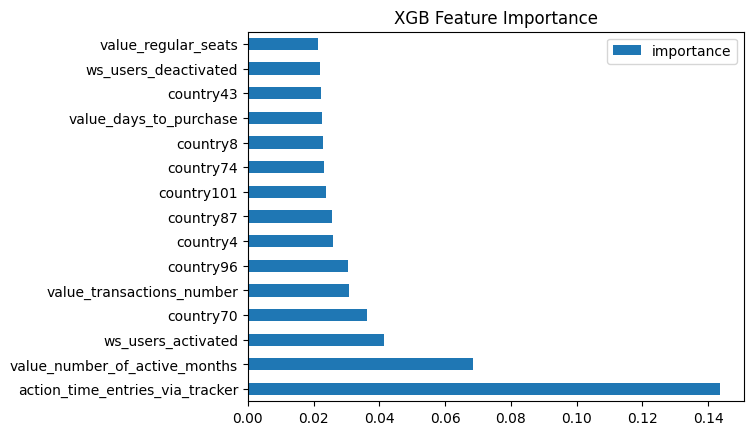

In [20]:
base_model = XGBClassifier(objective='binary:logistic', n_jobs = -1, eval_metric = 'auc')
test_par = {'max_depth' : [5,10,20,25,50,100],
            'learning_rate': [.01,.1,.2,.5],
            'n_estimators': [10,20,30,50],
            'min_child_weight': [.05,.15,.5,1]}
XGB_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = ['roc_auc','f1'], refit='f1', cv=10, verbose=4, n_jobs=-1)
XGB_gsearch.fit(X,y,sample_weight=get_weights(y))
XGB_result_df = pd.DataFrame(XGB_gsearch.cv_results_)

print(XGB_gsearch.best_score_)
print(XGB_gsearch.best_params_)

# Check feature importance
X_feature = X.columns.values
RF_feat = pd.DataFrame(data = XGB_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance',ascending=False)[0:15].plot(kind='barh', title = 'XGB Feature Importance')
plt.show()

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 6/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.569) roc_auc: (test=0.637) total time=   0.1s
[CV 8/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.546) roc_auc: (test=0.606) total time=   0.0s
[CV 3/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.318) roc_auc: (test=0.663) total time=   0.1s
[CV 2/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.275) roc_auc: (test=0.676) total time=   0.1s
[CV 4/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.554) roc_auc: (test=0.655) total time=   0.1s
[CV 7/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.579) roc_auc: (test=0.650) total time=   0.1s
[CV 1/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.393) roc_auc: (test=0.716) total time=   0.1s
[CV 5/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.535) roc_auc: (test=0.599) total time=   0.1s
[CV 10/10] END learning_rate=0.01, n_estimators=10; f1: (test=0.5

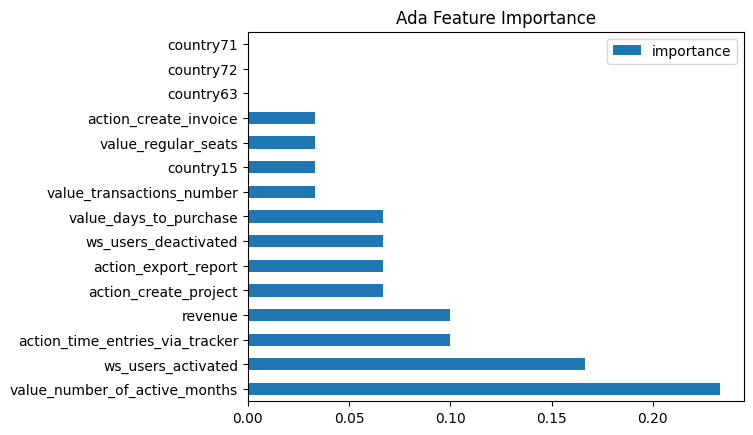

In [21]:
from sklearn.ensemble import AdaBoostClassifier
base_model = AdaBoostClassifier()
test_par ={ 'learning_rate': [.01,.1,.2,.5],
            'n_estimators': [10,20,30,50]} 
Ada_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = ['roc_auc','f1'], refit='f1', cv=10, verbose=4, n_jobs=-1)
Ada_gsearch.fit(X,y,sample_weight=get_weights(y))
#Ada_gsearch = pd.DataFrame(Ada_gsearch.cv_results_)

print(Ada_gsearch.best_score_)
print(Ada_gsearch.best_params_)

# Check feature importance
X_feature = X.columns.values
RF_feat = pd.DataFrame(data = Ada_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance',ascending=False)[0:15].plot(kind='barh', title = 'Ada Feature Importance')
plt.show()

In [22]:
from sklearn import metrics

def test_model(model : GridSearchCV) -> np.array : 
    y_test_pred = model.best_estimator_.predict_proba(X_test)[:,1]
    print('ROC_AUC for ' + str(model.estimator) + ' : ' + str(metrics.roc_auc_score(y_test,y_test_pred)))

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_test_pred)

    #create ROC curve
    plt.figure()
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    predicted_class = []
    threshold = .5

    predicted_class = [1 if x>threshold else 0 for x in y_test_pred]

    # Confusion matrix
    plt.figure()
    confusion_matrix = metrics.confusion_matrix(y_test, predicted_class, labels=XGB_gsearch.best_estimator_.classes_)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=XGB_gsearch.best_estimator_.classes_)
    cm_display.plot(cmap='RdPu')
    
    return confusion_matrix

ROC_AUC for LogisticRegression(class_weight='balanced', solver='liblinear') : 0.7492030696576151


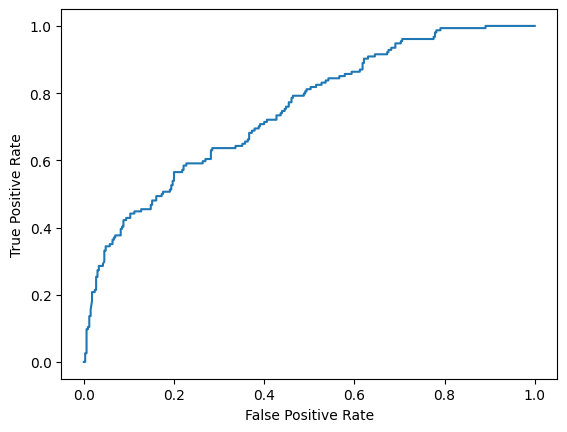

array([[202, 128],
       [ 46, 108]])

<Figure size 640x480 with 0 Axes>

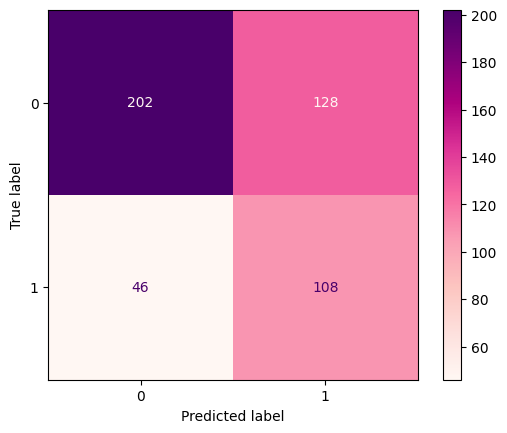

In [23]:
test_model(LR_gsearch)

ROC_AUC for RandomForestClassifier(class_weight='balanced', n_jobs=-1) : 0.7896497441951987


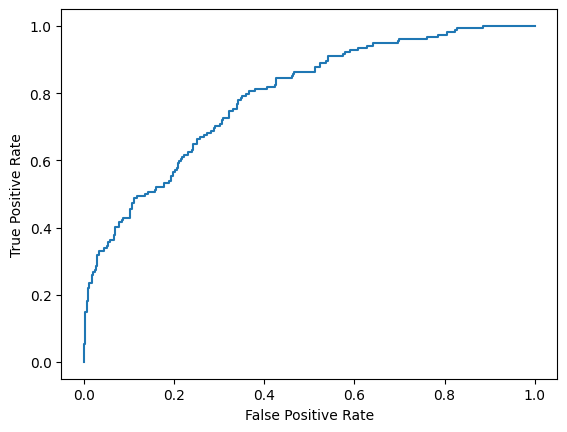

array([[221, 109],
       [ 39, 115]])

<Figure size 640x480 with 0 Axes>

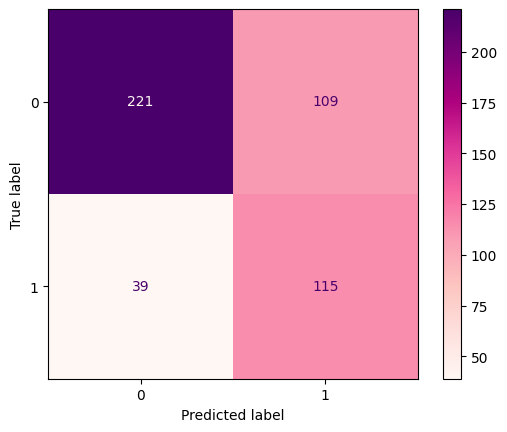

In [24]:
test_model(RF_gsearch)

ROC_AUC for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...) : 0.9919323101141283


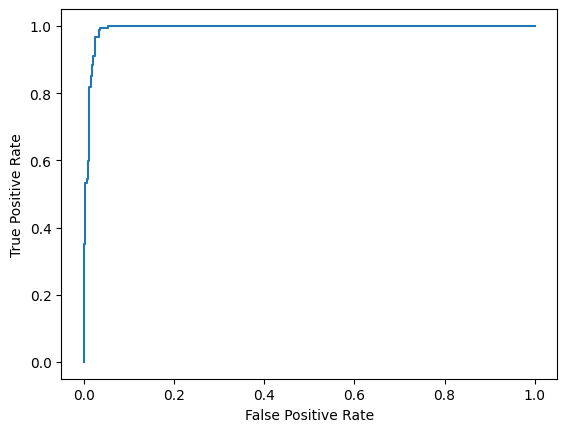

array([[312,  18],
       [  0, 154]])

<Figure size 640x480 with 0 Axes>

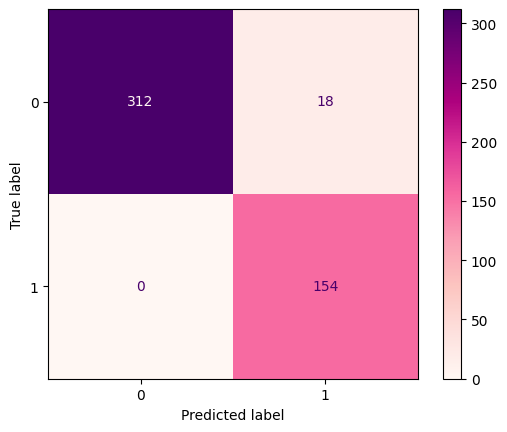

In [25]:
test_model(XGB_gsearch)

ROC_AUC for AdaBoostClassifier() : 0.8106946084218811


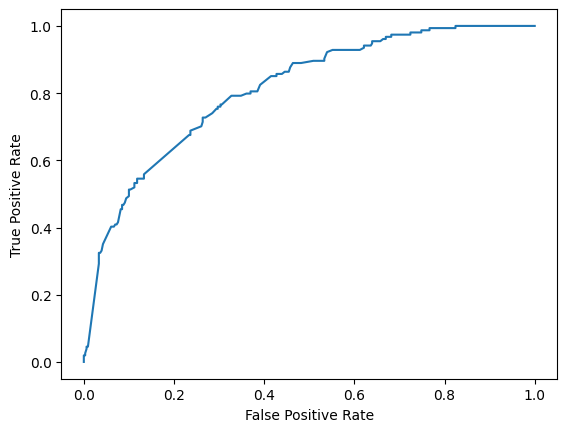

array([[230, 100],
       [ 36, 118]])

<Figure size 640x480 with 0 Axes>

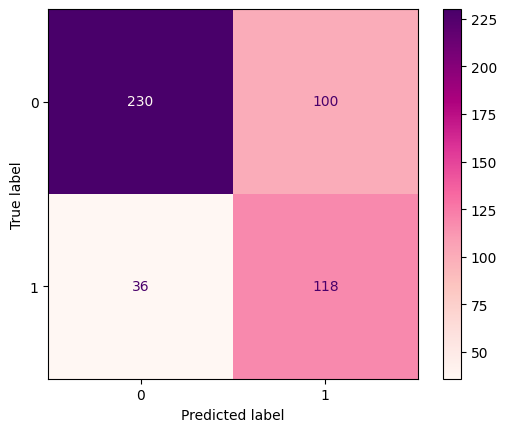

In [26]:
test_model(Ada_gsearch)

Finally, we see that XGBoost shows best performance on the test set. While the XGBoost and RF both have nearly identcial f1 scores of when calculated on the training set, the difference in the confusion matrix shows that the XGBoost has a much better performance with the unseen data. If we go into the training logs, we will notice very similar training results. This leads us to conclude the architecture of the model had a lot of to atttribute. We end up chosing the XGBooster out of the 4.

In the end, we may conclude that we have a good model for estimating churn. From the feature importance and even cohort functions, we can gather even more useful information, such as which areas of product are most deserving for churn happening. This would help the advertising and engineering teams know where to focus their attention.

Time spent od the app, as well as the number of months a client uses our product is of greatest relavance to the outcome. If we look at the cohort functions, we will notice that we are more likely to keep the clients that have been with us for a longer period of time. This would suggest our product perhaps needs more user-friendly design, better marketing, client support etc. We also see that the more regular seats the client has, the less likely they are to leave.  And, in the end, we see that the counrty plays a big role i  whether we have 'churn' or 'active'.